In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

from sequential_ft_transformer.fttransformer import FTTransformer
from sequential_ft_transformer.preprocessing import sq_df_to_dataset, download_data
from sequential_ft_transformer.plotting import plot_importances, plot_training_hist


2024-04-07 21:39:47.195005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Download Data

In [2]:
data_folder = "../data/"
seq_length = 1

In [3]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

download_data(train_data_url, data_folder, "adult_train.csv")
download_data(test_data_url, data_folder, "adult_test.csv")

train_data = pd.read_csv(os.path.join(data_folder, "adult_train.csv"), header=None, names=CSV_HEADER)
test_data = pd.read_csv(os.path.join(data_folder, "adult_test.csv"), header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

adult_train.csv already exists in ../data/
adult_test.csv already exists in ../data/
Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [4]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess

In [5]:
# Column information
NUMERIC_FEATURES = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
NUMERIC_FEATURES = sorted(NUMERIC_FEATURES)
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country']
CATEGORICAL_FEATURES = sorted(CATEGORICAL_FEATURES)

FEATURES = sorted(list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES))
LABEL = 'income_bracket'

In [6]:
# encoding as binary target
train_data[LABEL] = train_data[LABEL].apply(lambda x: int(x == ' >50K')) 
test_data[LABEL] = test_data[LABEL].apply(lambda x: int(x == ' >50K.'))

In [7]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [8]:
train_input = train_data[FEATURES]
train_labels = train_data[LABEL]

test_input = test_data[FEATURES]
test_labels = test_data[LABEL]

## Get Lookup Tables for Each Categorical Column

In [9]:
cat_lookups = dict()
feature_unique_counts = dict()
num_oov_indices = 1
for cat in CATEGORICAL_FEATURES:
    unique_values = list(np.unique(train_input[cat]).astype(str))
    feature_unique_counts[cat] = len(unique_values) + num_oov_indices
    lookup = keras.layers.StringLookup(vocabulary=unique_values, num_oov_indices=num_oov_indices)
    cat_lookups[cat] = lookup

2024-04-07 21:39:47.517428: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Convert Each Categorical String to an ID

In [10]:
for cat in CATEGORICAL_FEATURES:
    train_input[cat] = cat_lookups[cat](train_input[cat])
    test_input[cat] = cat_lookups[cat](test_input[cat])

/tmp/ipykernel_347958/1451819549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_input[cat] = cat_lookups[cat](train_input[cat])
/tmp/ipykernel_347958/1451819549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_input[cat] = cat_lookups[cat](test_input[cat])


In [11]:
train_input.loc[:, CATEGORICAL_FEATURES] = train_input[CATEGORICAL_FEATURES].astype(int)
test_input.loc[:, CATEGORICAL_FEATURES] = test_input[CATEGORICAL_FEATURES].astype(int)

train_input.loc[:, NUMERIC_FEATURES] = train_input[NUMERIC_FEATURES].astype(float)
test_input.loc[:, NUMERIC_FEATURES] = test_input[NUMERIC_FEATURES].astype(float)

In [12]:
train_labels = train_labels.to_frame(name=LABEL)
test_labels = test_labels.to_frame(name=LABEL)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(train_input, train_labels, test_size=0.2)

## Create TF Datasets

In [14]:
batch_size = 1000
train_dataset = sq_df_to_dataset(
    x_train, 
    seq_length, 
    target_df=y_train, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    batch_size=batch_size
)
val_dataset = sq_df_to_dataset(
    x_val, 
    seq_length, 
    target_df=y_val, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, # No shuffle
    batch_size=batch_size
)  
test_dataset = sq_df_to_dataset(
    test_input, 
    seq_length, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, 
    batch_size=batch_size) # No target, no shuffle

## Periodic Numerical Embedding FT-Transformer

In [15]:
# Explanations need to be set to false until the following bug is fixed: https://github.com/keras-team/keras/issues/19303
EXPLANATIONS = False 
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 10
N_BINS = 10

In [16]:
model = FTTransformer(
    out_dim=1,
    out_activation='sigmoid',
    feature_unique_counts=feature_unique_counts,
    numerical_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    seq_length=seq_length,
    numerical_embedding_type='periodic',
    n_bins=N_BINS,
    explainable=EXPLANATIONS    
)

optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss = keras.losses.BinaryCrossentropy()
metrics = [keras.metrics.AUC(name="PR AUC", curve='PR')]
# Explanations need to be reworked once the bug is fixed
# if EXPLANATIONS:
#     loss_dict.update({"importances": None})
#     metrics_dict.update({"importances": None})
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

early = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

/home/ubuntu22/repos/sequential-ft-transformer/venv/lib/python3.10/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'cat_inputs' mapping to value <KerasTensor shape=(None, 1, 8), dtype=float32, sparse=None, name=keras_tensor> which has name 'keras_tensor'. Change the tensor name to 'cat_inputs' (via `Input(..., name='cat_inputs')`)
  warnings.warn(
/home/ubuntu22/repos/sequential-ft-transformer/venv/lib/python3.10/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'numeric_inputs' mapping to value <KerasTensor shape=(None, 1, 5), dtype=float32, sparse=None, name=keras_tensor_1> which has name 'keras_tensor_1'. Change the tensor name to 'numeric_inputs' (via `Input(..., name='numeric_inputs')`)
  warnings.warn(


In [17]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/10
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.4694 - loss: 0.4720

2024-04-07 21:40:21.329899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - PR AUC: 0.4738 - loss: 0.4698

2024-04-07 21:40:30.338355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 479ms/step - PR AUC: 0.4779 - loss: 0.4677 - val_PR AUC: 0.6980 - val_loss: 0.3637
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - PR AUC: 0.7083 - loss: 0.3509 - val_PR AUC: 0.7321 - val_loss: 0.3511
Epoch 3/10


2024-04-07 21:40:34.249471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:40:34.295255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - PR AUC: 0.7249 - loss: 0.3434 - val_PR AUC: 0.7298 - val_loss: 0.3401
Epoch 4/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - PR AUC: 0.7515 - loss: 0.3109

2024-04-07 21:40:34.668767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:40:34.713203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.7259 - loss: 0.3355 - val_PR AUC: 0.7340 - val_loss: 0.3430
Epoch 5/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.7281 - loss: 0.3420 

2024-04-07 21:40:35.082530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:40:35.126479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - PR AUC: 0.7316 - loss: 0.3366 - val_PR AUC: 0.7307 - val_loss: 0.3366
Epoch 6/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - PR AUC: 0.7661 - loss: 0.3122

2024-04-07 21:40:35.400288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:40:35.446218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.7435 - loss: 0.3325 - val_PR AUC: 0.7355 - val_loss: 0.3367
Epoch 7/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7399 - loss: 0.3366

2024-04-07 21:40:35.817748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:40:35.863301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.7304 - loss: 0.3365 - val_PR AUC: 0.7302 - val_loss: 0.3363
Epoch 8/10


2024-04-07 21:40:36.144201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:40:36.235711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - PR AUC: 0.7376 - loss: 0.3339 - val_PR AUC: 0.7391 - val_loss: 0.3349
Epoch 9/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - PR AUC: 0.6800 - loss: 0.3583

2024-04-07 21:40:36.630941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:40:36.674135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - PR AUC: 0.7315 - loss: 0.3363 - val_PR AUC: 0.7366 - val_loss: 0.3327
Epoch 10/10


2024-04-07 21:40:37.031455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:40:37.076428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7413 - loss: 0.3267 - val_PR AUC: 0.7332 - val_loss: 0.3366


2024-04-07 21:40:37.444892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:40:37.487924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


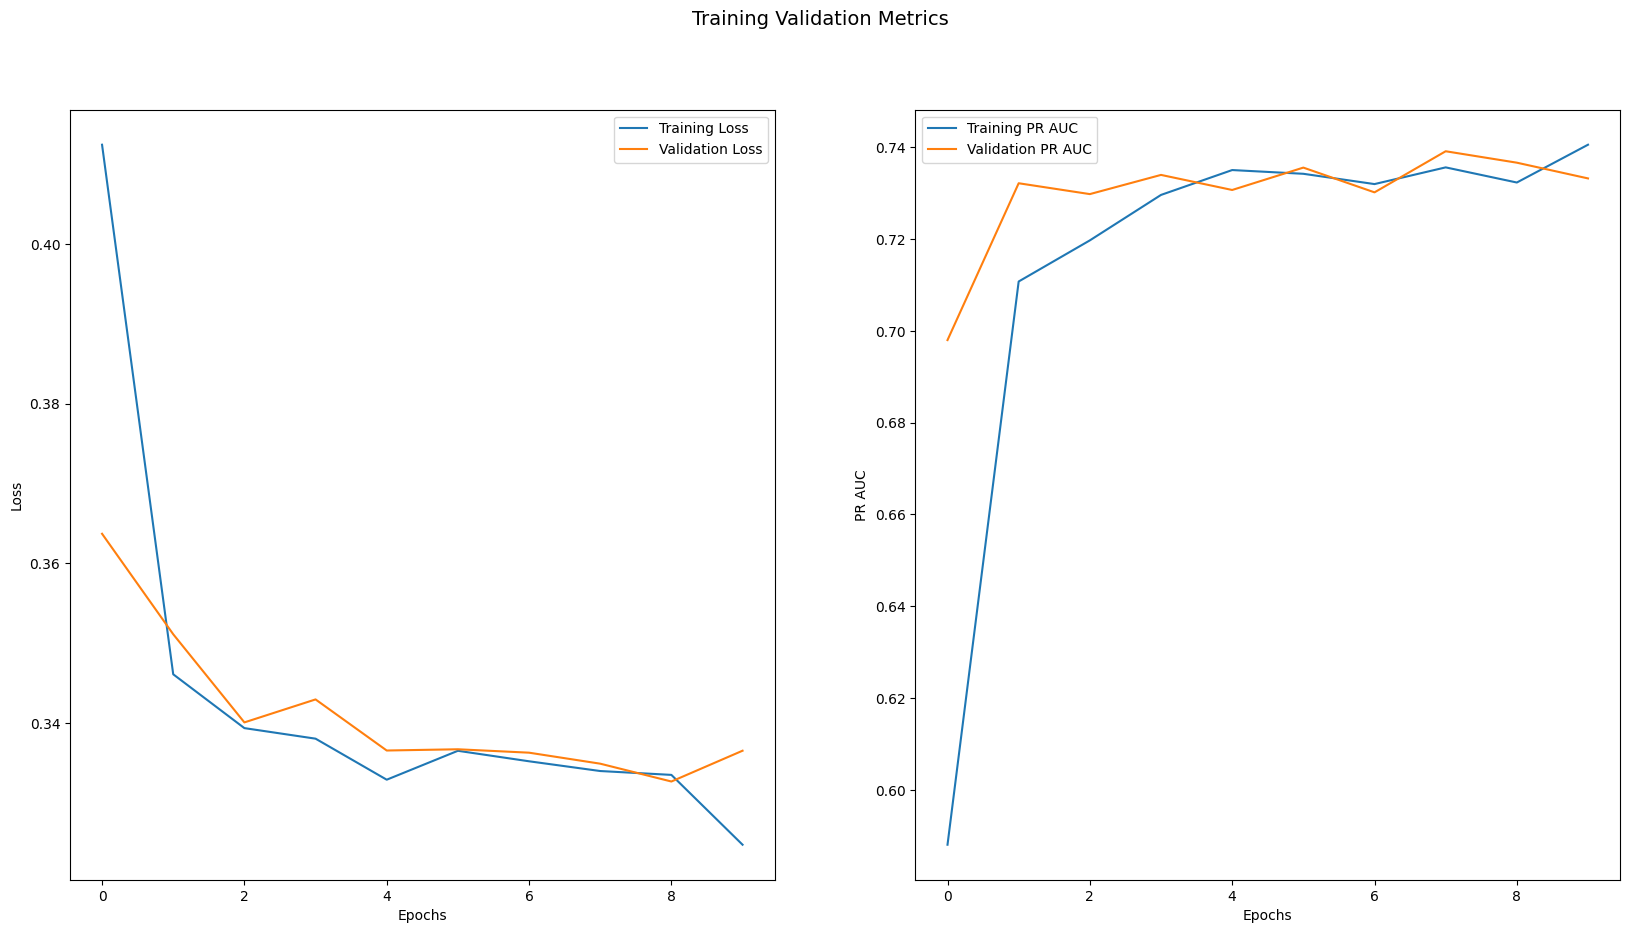

In [18]:
hist_plot = plot_training_hist(hist.history, EXPLANATIONS)

In [19]:
preds = model.predict(test_dataset)
flat_preds = preds.ravel()
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], flat_preds), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], flat_preds), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], flat_preds > 0.5), 4))

# Reported accuracy - 0.858

 1/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step

2024-04-07 21:40:39.064919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step
Test ROC AUC: 0.8961
Test PR AUC: 0.7311
Test Accuracy: 0.8474


## Explainability

In [20]:
# if 'importances' in preds.keys():
#     importances = preds['importances']
#     importances_df = pd.DataFrame(importances[:, :-1], columns = FEATURES)
#     importances_fig, total_importances = plot_importances(
#         importances_df, 
#         title="Importances for FT-Transformer"
#     )